<a href="https://colab.research.google.com/github/michaelywg/images/blob/master/part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Part 3: Train With Larger Dataset

First, let's load in the dataset and a pre-trained model to build off of.

In [2]:
# Load in the training and validation data
%%capture
import os 
if not os.path.exists('/content/ibug_300W_large_face_landmark_dataset'):
    !wget https://people.eecs.berkeley.edu/~zhecao/ibug_300W_large_face_landmark_dataset.zip
    !unzip 'ibug_300W_large_face_landmark_dataset.zip'    
    !rm -r 'ibug_300W_large_face_landmark_dataset.zip'

In [3]:
#import a pre-trained resnet18 model
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


### Dataloader
For this model, I wrote a custom dataloader to crop each facial image, resize it to 224x224, and get keypoint coordinates. I also applied the same data augmentation transformations as in part 2.

In [4]:
# Dataloader
import xml.etree.ElementTree as ET 
import numpy as np
import os 

tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
root = tree.getroot()
root_dir = 'ibug_300W_large_face_landmark_dataset'

bboxes = [] # face bounding box used to crop the image
landmarks = [] # the facial keypoints/landmarks for the whole training dataset
img_filenames = [] # the image names for the whole dataset

for filename in root[2]:
	img_filenames.append(os.path.join(root_dir, filename.attrib['file']))
	box = filename[0].attrib
	# x, y for the top left corner of the box, w, h for box width and height
	bboxes.append([box['left'], box['top'], box['width'], box['height']]) 

	landmark = []
	for num in range(68):
		x_coordinate = int(filename[0][num].attrib['x'])
		y_coordinate = int(filename[0][num].attrib['y'])
		landmark.append([x_coordinate, y_coordinate])
	landmarks.append(landmark)

landmarks = np.array(landmarks).astype('float32')     
bboxes = np.array(bboxes).astype('float32')


In [33]:
for i in range(len(bboxes)):
  xunit, yunit = 0.1 * bboxes[i][0], 0.1 * bboxes[i][1]
  bboxes[i][0] -= xunit
  bboxes[i][1] -= yunit
  bboxes[i][2] += 2 * xunit
  bboxes[i][3] += 2 * yunit

In [38]:
# Actual Dataset for images, along with transformations for data augmentation
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch
import skimage
from skimage import io as skio, transform
import warnings
# ignore warnings
warnings.filterwarnings("ignore")
torch.manual_seed(69)

class BigFaceDataset(Dataset):
    def __init__(self, image_fnames, landmarks, bboxes, transform=None):
        self.image_fnames = image_fnames[:]
        self.landmarks = landmarks[:]
        self.bboxes = bboxes[:]
        self.transform = transform

    def __len__(self):
        return len(self.image_fnames)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.to_list()
        result = dict()
        left, top, width, height = [int(pt) for pt in self.bboxes[idx]]
        left = int(max(0, left - 0.1 * width))
        top = int(max(0, top - 0.1 * height))
        width = int(width * 1.2)
        height = int(height * 1.2)
        landmarks = torch.Tensor(self.landmarks[idx]).detach().clone()
        landmarks[:, 0] = (landmarks[:, 0] - left) / width
        landmarks[:, 1] = (landmarks[:, 1] - top) / height
        image = skimage.color.rgb2gray(
            skio.imread(self.image_fnames[idx]))[top:top + height, left:left + width]
        image = transform.resize(image, (224, 224))
        if self.transform:
            image, landmarks = self.transform(image, landmarks)
        result['landmarks'] = landmarks
        result['image'] = torch.Tensor([image - 0.5])
        return result

# Define random transformations to augment the dataset and improve training robustness
class JitterColors:
    # Randomly jitter the brightness and saturation of an image
    def __call__(self, image, landmarks):
        return transforms.ColorJitter()(image), landmarks

class RandomRotation:
    def __init__(self, min_angle, max_angle):
        self.min_angle = min_angle
        self.max_angle = max_angle
        
    def __call__(self, image, landmarks):
        degrees = np.random.randint(self.min_angle, self.max_angle + 1)
        radians = -degrees * np.pi / 180.0
        image = transform.rotate(image, degrees)
        matrix = np.array([[np.cos(radians), -np.sin(radians)], [np.sin(radians), np.cos(radians)]])
        landmarks = torch.Tensor((np.matmul(matrix, landmarks.numpy().T - 0.5)).T) + 0.5
        return image, landmarks

class RandomShift:
    def __init__(self, min_px, max_px):
        self.min_px = min_px
        self.max_px = max_px
    
    def __call__(self, image, landmarks):
        vertical = np.random.randint(self.min_px, self.max_px + 1)
        horizontal = np.random.randint(self.min_px, self.max_px + 1)
        image = np.roll(image, vertical, axis=0)
        image = np.roll(image, horizontal, axis=1)
        landmarks[:, 0] += horizontal/224.0
        landmarks[:, 1] += vertical/224.0
        return image, landmarks

class RandomHorizontalFlip:
    def __call__(self, image, landmarks):
        if np.random.randint(0, 2) == 1:
            image = image[:, ::-1]
            landmarks = landmarks.detach().clone()
            landmarks[:, 0] = 1 - landmarks[:, 0]
        return image, landmarks
    
# Callable class combining the above transformations
class AugmentData:
    def __call__(self, image, landmarks):
        for fn in [
            JitterColors(),
            RandomRotation(-15, 15),
            RandomShift(-10, 10),
            RandomHorizontalFlip()
            ]:
            image, landmarks = fn(image, landmarks)
        return image, landmarks

In [39]:
i = 1
l, t, w, h = bboxes[i]
print(t, t + h)
print(np.min(landmarks[i][:, 0]), np.max(landmarks[i][:, 0]))
print(l, l + w)
print(np.min(landmarks[i][:, 1]), np.max(landmarks[i][:, 1]))

117.0 590.0
97.0 575.0
27.9 481.1
150.0 600.0


In [43]:
big_train_dataset = BigFaceDataset(img_filenames, landmarks, bboxes, transform=AugmentData())

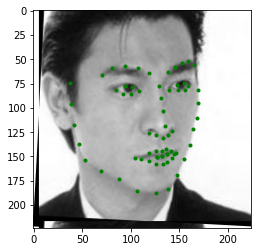

In [44]:
entry = big_train_dataset[12]
plt.imshow(entry['image'].squeeze(0), cmap='gray')
for x, y in entry['landmarks']:
  x, y = 224 * x, 224 * y
  plt.plot(x, y, 'go', ms=3)